In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.2.0-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [ ]:
from google.colab import drive

drive.mount('/drive')

Mounted at /drive


In [ ]:
from pyspark.sql import SparkSession
from pyspark.mllib.stat import Statistics
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.clustering import LDA
import numpy as np
import pandas as pd

# Reading the data 

In [ ]:
app_train = spark.read.option("header",True) \
     .csv("/drive/MyDrive/Home_Loan default/application_train.csv",inferSchema=True)
prev_app = spark.read.option("header",True) \
     .csv("/drive/MyDrive/Home_Loan default/previous_application.csv",inferSchema=True)
pos_cash = spark.read.option("header",True) \
     .csv("/drive/MyDrive/Home_Loan default/POS_CASH_balance.csv",inferSchema=True)
install_payments = spark.read.option("header",True) \
     .csv("/drive/MyDrive/Home_Loan default/installments_payments.csv",inferSchema=True)
credit_bal = spark.read.option("header",True) \
     .csv("/drive/MyDrive/Home_Loan default/credit_card_balance.csv",inferSchema=True)
bureau_bal = spark.read.option("header",True) \
     .csv("/drive/MyDrive/Home_Loan default/bureau_balance.csv",inferSchema=True)
bureau = spark.read.option("header",True) \
     .csv("/drive/MyDrive/Home_Loan default/bureau.csv",inferSchema=True)
    

In [ ]:
print(app_train.show(1),prev_app.show(1),pos_cash.show(1),install_payments.show(1),credit_bal.show(1),bureau_bal.show(1),bureau.show(1))

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+----------------+--------------------+--------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+--------------------+-------------------+------------------+-------------------+--------------+----------------+---------------------------+---------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+--------------------

In [ ]:
print(app_train.count(),prev_app.count(),pos_cash.count(),install_payments.count(),credit_bal.count(),bureau_bal.count(),bureau.count())

307511 1670214 10001358 13605401 3840312 27299925 1716428


In [ ]:
prev_app.createOrReplaceTempView("prev_app")
app_train.createOrReplaceTempView("app_train")
bureau.createOrReplaceTempView("bureau")
pos_cash.createOrReplaceTempView("pos_cash")
install_payments.createOrReplaceTempView("install_payments")
credit_bal.createOrReplaceTempView("credit_bal")
check = spark.sql('''select SK_ID_CURR from app_train''')
check_1 = spark.sql('''select distinct SK_ID_CURR from prev_app''')

In [ ]:
check.show()

+----------+
|SK_ID_CURR|
+----------+
|    100002|
|    100003|
|    100004|
|    100006|
|    100007|
|    100008|
|    100009|
|    100010|
|    100011|
|    100012|
|    100014|
|    100015|
|    100016|
|    100017|
|    100018|
|    100019|
|    100020|
|    100021|
|    100022|
|    100023|
+----------+
only showing top 20 rows



In [ ]:
check.count()

307511

In [ ]:
check_1.intersect(check).count()

291057

In [ ]:
app_train.show()

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+--------------------+--------------------+--------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+--------------------+-------------------+-------------------+-------------------+--------------+----------------+---------------------------+------------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+------------

In [ ]:
app_train.count()

307511

In [ ]:
len(app_train.columns)

122

In [ ]:
prev_app = spark.read.option("header",True) \
     .csv("/drive/MyDrive/Home_Loan default/previous_application.csv")

In [ ]:
prev_app.show()

+----------+----------+------------------+-----------+---------------+----------+----------------+---------------+--------------------------+-----------------------+---------------------------+----------------------+-------------------+---------------------+------------------------+----------------------+--------------------+-------------+--------------------+------------------+---------------+----------------+--------------------+--------------+-----------------+--------------------+----------------+--------------------+-----------+----------------+--------------------+------------------+--------------+-------------------------+-------------+----------------+-------------------------+
|SK_ID_PREV|SK_ID_CURR|NAME_CONTRACT_TYPE|AMT_ANNUITY|AMT_APPLICATION|AMT_CREDIT|AMT_DOWN_PAYMENT|AMT_GOODS_PRICE|WEEKDAY_APPR_PROCESS_START|HOUR_APPR_PROCESS_START|FLAG_LAST_APPL_PER_CONTRACT|NFLAG_LAST_APPL_IN_DAY|  RATE_DOWN_PAYMENT|RATE_INTEREST_PRIMARY|RATE_INTEREST_PRIVILEGED|NAME_CASH_LOAN_PURPOSE

In [ ]:
spark.sql('''select distinct SK_ID_CURR from prev_app''').count()
spark.sql('''select distinct SK_ID_CURR from app_train''').count()

307511

So there are 307511 current customers, out of which we have 291057, has previous data of other loans from the same company  

In [ ]:
app_train.columns

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

In [ ]:
prev_app.columns

['SK_ID_PREV',
 'SK_ID_CURR',
 'NAME_CONTRACT_TYPE',
 'AMT_ANNUITY',
 'AMT_APPLICATION',
 'AMT_CREDIT',
 'AMT_DOWN_PAYMENT',
 'AMT_GOODS_PRICE',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NFLAG_LAST_APPL_IN_DAY',
 'RATE_DOWN_PAYMENT',
 'RATE_INTEREST_PRIMARY',
 'RATE_INTEREST_PRIVILEGED',
 'NAME_CASH_LOAN_PURPOSE',
 'NAME_CONTRACT_STATUS',
 'DAYS_DECISION',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_TYPE_SUITE',
 'NAME_CLIENT_TYPE',
 'NAME_GOODS_CATEGORY',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'SELLERPLACE_AREA',
 'NAME_SELLER_INDUSTRY',
 'CNT_PAYMENT',
 'NAME_YIELD_GROUP',
 'PRODUCT_COMBINATION',
 'DAYS_FIRST_DRAWING',
 'DAYS_FIRST_DUE',
 'DAYS_LAST_DUE_1ST_VERSION',
 'DAYS_LAST_DUE',
 'DAYS_TERMINATION',
 'NFLAG_INSURED_ON_APPROVAL']

In [ ]:
prev_app.show()

+----------+----------+------------------+-----------+---------------+----------+----------------+---------------+--------------------------+-----------------------+---------------------------+----------------------+-------------------+---------------------+------------------------+----------------------+--------------------+-------------+--------------------+------------------+---------------+----------------+--------------------+--------------+-----------------+--------------------+----------------+--------------------+-----------+----------------+--------------------+------------------+--------------+-------------------------+-------------+----------------+-------------------------+
|SK_ID_PREV|SK_ID_CURR|NAME_CONTRACT_TYPE|AMT_ANNUITY|AMT_APPLICATION|AMT_CREDIT|AMT_DOWN_PAYMENT|AMT_GOODS_PRICE|WEEKDAY_APPR_PROCESS_START|HOUR_APPR_PROCESS_START|FLAG_LAST_APPL_PER_CONTRACT|NFLAG_LAST_APPL_IN_DAY|  RATE_DOWN_PAYMENT|RATE_INTEREST_PRIMARY|RATE_INTEREST_PRIVILEGED|NAME_CASH_LOAN_PURPOSE

In [ ]:
list(set(prev_app.columns).intersection(app_train.columns))

['AMT_CREDIT',
 'NAME_CONTRACT_TYPE',
 'SK_ID_CURR',
 'AMT_GOODS_PRICE',
 'WEEKDAY_APPR_PROCESS_START',
 'NAME_TYPE_SUITE',
 'AMT_ANNUITY',
 'HOUR_APPR_PROCESS_START']

Do EDA differently and clean the files saperately and find the features right features for building the model 

In [ ]:
app_train.show()

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+--------------------+--------------------+--------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+--------------------+-------------------+-------------------+-------------------+--------------+----------------+---------------------------+------------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+------------

In [ ]:
app_train.describe()

DataFrame[summary: string, SK_ID_CURR: string, TARGET: string, NAME_CONTRACT_TYPE: string, CODE_GENDER: string, FLAG_OWN_CAR: string, FLAG_OWN_REALTY: string, CNT_CHILDREN: string, AMT_INCOME_TOTAL: string, AMT_CREDIT: string, AMT_ANNUITY: string, AMT_GOODS_PRICE: string, NAME_TYPE_SUITE: string, NAME_INCOME_TYPE: string, NAME_EDUCATION_TYPE: string, NAME_FAMILY_STATUS: string, NAME_HOUSING_TYPE: string, REGION_POPULATION_RELATIVE: string, DAYS_BIRTH: string, DAYS_EMPLOYED: string, DAYS_REGISTRATION: string, DAYS_ID_PUBLISH: string, OWN_CAR_AGE: string, FLAG_MOBIL: string, FLAG_EMP_PHONE: string, FLAG_WORK_PHONE: string, FLAG_CONT_MOBILE: string, FLAG_PHONE: string, FLAG_EMAIL: string, OCCUPATION_TYPE: string, CNT_FAM_MEMBERS: string, REGION_RATING_CLIENT: string, REGION_RATING_CLIENT_W_CITY: string, WEEKDAY_APPR_PROCESS_START: string, HOUR_APPR_PROCESS_START: string, REG_REGION_NOT_LIVE_REGION: string, REG_REGION_NOT_WORK_REGION: string, LIVE_REGION_NOT_WORK_REGION: string, REG_CITY_N

In [ ]:
app_train.dtypes 

[('SK_ID_CURR', 'int'),
 ('TARGET', 'int'),
 ('NAME_CONTRACT_TYPE', 'string'),
 ('CODE_GENDER', 'string'),
 ('FLAG_OWN_CAR', 'string'),
 ('FLAG_OWN_REALTY', 'string'),
 ('CNT_CHILDREN', 'int'),
 ('AMT_INCOME_TOTAL', 'double'),
 ('AMT_CREDIT', 'double'),
 ('AMT_ANNUITY', 'double'),
 ('AMT_GOODS_PRICE', 'double'),
 ('NAME_TYPE_SUITE', 'string'),
 ('NAME_INCOME_TYPE', 'string'),
 ('NAME_EDUCATION_TYPE', 'string'),
 ('NAME_FAMILY_STATUS', 'string'),
 ('NAME_HOUSING_TYPE', 'string'),
 ('REGION_POPULATION_RELATIVE', 'double'),
 ('DAYS_BIRTH', 'int'),
 ('DAYS_EMPLOYED', 'int'),
 ('DAYS_REGISTRATION', 'double'),
 ('DAYS_ID_PUBLISH', 'int'),
 ('OWN_CAR_AGE', 'double'),
 ('FLAG_MOBIL', 'int'),
 ('FLAG_EMP_PHONE', 'int'),
 ('FLAG_WORK_PHONE', 'int'),
 ('FLAG_CONT_MOBILE', 'int'),
 ('FLAG_PHONE', 'int'),
 ('FLAG_EMAIL', 'int'),
 ('OCCUPATION_TYPE', 'string'),
 ('CNT_FAM_MEMBERS', 'double'),
 ('REGION_RATING_CLIENT', 'int'),
 ('REGION_RATING_CLIENT_W_CITY', 'int'),
 ('WEEKDAY_APPR_PROCESS_START', '

# Data Wrangling

In [ ]:
from pyspark.sql.functions import col,count,isnan,when
r = []
rd = app_train.select([count(when(col(c).isNull(), c)).alias(c) for c in app_train.columns])
for i in range(len(app_train.columns)):
  # print(rd[i],rd.collect()[0][i]/app_train.count())
  # r = rd.collect()[0][i]/app_train.count()>0.5
  if(rd.collect()[0][i]/app_train.count()>0.5):
    r.append(rd.columns[i])


In [ ]:
len(r)

41

In [ ]:
r[1]

'EXT_SOURCE_1'

**Deleting the columns with more than 50% of null values**

In [ ]:
for i in r:
  app_train = app_train.drop(i)

In [ ]:
len(app_train.columns)

81

In [ ]:
app_train.select([count(when(col(c).isNull(), c)).alias(c) for c in app_train.columns]).show()

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+----------------+-------------------+------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+-----------------+------------+------------+---------------------------+-------------+----------------------------+--------------+----------------------------+--------------+--------------+-------------------+------------------------+------------------------+------------------------+------------------------+--

In [ ]:
from pyspark.sql.functions import col,count,isnan,when
rd_1 = app_train.select([count(when(col(c).isNull(), c)).alias(c) for c in app_train.columns])
for i in range(len(app_train.columns)):
  if(rd_1.collect()[0][i]>0):
    print(rd_1[i])

 

Column<'AMT_ANNUITY'>
Column<'AMT_GOODS_PRICE'>
Column<'NAME_TYPE_SUITE'>
Column<'OCCUPATION_TYPE'>
Column<'CNT_FAM_MEMBERS'>
Column<'EXT_SOURCE_2'>
Column<'EXT_SOURCE_3'>
Column<'YEARS_BEGINEXPLUATATION_AVG'>
Column<'FLOORSMAX_AVG'>
Column<'YEARS_BEGINEXPLUATATION_MODE'>
Column<'FLOORSMAX_MODE'>
Column<'YEARS_BEGINEXPLUATATION_MEDI'>
Column<'FLOORSMAX_MEDI'>
Column<'TOTALAREA_MODE'>
Column<'EMERGENCYSTATE_MODE'>
Column<'OBS_30_CNT_SOCIAL_CIRCLE'>
Column<'DEF_30_CNT_SOCIAL_CIRCLE'>
Column<'OBS_60_CNT_SOCIAL_CIRCLE'>
Column<'DEF_60_CNT_SOCIAL_CIRCLE'>
Column<'DAYS_LAST_PHONE_CHANGE'>
Column<'AMT_REQ_CREDIT_BUREAU_HOUR'>
Column<'AMT_REQ_CREDIT_BUREAU_DAY'>
Column<'AMT_REQ_CREDIT_BUREAU_WEEK'>
Column<'AMT_REQ_CREDIT_BUREAU_MON'>
Column<'AMT_REQ_CREDIT_BUREAU_QRT'>
Column<'AMT_REQ_CREDIT_BUREAU_YEAR'>


In [ ]:
from pyspark.ml.feature import Imputer
imputer = Imputer(
    inputCols=['AMT_ANNUITY','AMT_GOODS_PRICE','CNT_FAM_MEMBERS','EXT_SOURCE_2','EXT_SOURCE_3','YEARS_BEGINEXPLUATATION_AVG','FLOORSMAX_AVG','TOTALAREA_MODE','OBS_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE','DAYS_LAST_PHONE_CHANGE'], 
    outputCols=['AMT_ANNUITY','AMT_GOODS_PRICE','CNT_FAM_MEMBERS','EXT_SOURCE_2','EXT_SOURCE_3','YEARS_BEGINEXPLUATATION_AVG','FLOORSMAX_AVG','TOTALAREA_MODE','OBS_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE','DAYS_LAST_PHONE_CHANGE']
    ).setStrategy("mean")

In [ ]:
model = imputer.fit(app_train)
app_train_imputed = model.transform(app_train)

In [ ]:
app_train_imputed.select([count(when(col(c).isNull(), c)).alias(c) for c in app_train_imputed.columns]).show()

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+----------------+-------------------+------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+-----------------+------------+------------+---------------------------+-------------+----------------------------+--------------+----------------------------+--------------+--------------+-------------------+------------------------+------------------------+------------------------+------------------------+--

In [ ]:
from pyspark.sql.functions import col,count,isnan,when
rd_1 = app_train_imputed.select([count(when(col(c).isNull(), c)).alias(c) for c in app_train_imputed.columns])
for i in range(len(app_train_imputed.columns)):
  if(rd_1.collect()[0][i]>0):
    print(rd_1[i])

Column<'NAME_TYPE_SUITE'>
Column<'OCCUPATION_TYPE'>
Column<'YEARS_BEGINEXPLUATATION_MODE'>
Column<'FLOORSMAX_MODE'>
Column<'YEARS_BEGINEXPLUATATION_MEDI'>
Column<'FLOORSMAX_MEDI'>
Column<'EMERGENCYSTATE_MODE'>
Column<'AMT_REQ_CREDIT_BUREAU_HOUR'>
Column<'AMT_REQ_CREDIT_BUREAU_DAY'>
Column<'AMT_REQ_CREDIT_BUREAU_WEEK'>
Column<'AMT_REQ_CREDIT_BUREAU_MON'>
Column<'AMT_REQ_CREDIT_BUREAU_QRT'>
Column<'AMT_REQ_CREDIT_BUREAU_YEAR'>


In [ ]:
app_train_imputed = app_train_imputed.drop('AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR')

In [ ]:
from pyspark.sql.functions import col,count,isnan,when
rd_1 = app_train_imputed.select([count(when(col(c).isNull(), c)).alias(c) for c in app_train_imputed.columns])
for i in range(len(app_train_imputed.columns)):
  if(rd_1.collect()[0][i]>0):
    print(rd_1[i])

Column<'NAME_TYPE_SUITE'>
Column<'OCCUPATION_TYPE'>
Column<'YEARS_BEGINEXPLUATATION_MODE'>
Column<'FLOORSMAX_MODE'>
Column<'YEARS_BEGINEXPLUATATION_MEDI'>
Column<'FLOORSMAX_MEDI'>
Column<'EMERGENCYSTATE_MODE'>


In [ ]:
app_train_imputed = app_train_imputed.drop('YEARS_BEGINEXPLUATATION_MODE','FLOORSMAX_MODE','YEARS_BEGINEXPLUATATION_MEDI','FLOORSMAX_MEDI','EMERGENCYSTATE_MODE')

In [ ]:
from pyspark.sql.functions import col,count,isnan,when
rd_1 = app_train_imputed.select([count(when(col(c).isNull(), c)).alias(c) for c in app_train_imputed.columns])
for i in range(len(app_train_imputed.columns)):
  if(rd_1.collect()[0][i]>0):
    print(rd_1[i])

Column<'NAME_TYPE_SUITE'>
Column<'OCCUPATION_TYPE'>


In [ ]:
imputer = Imputer(
    inputCols=['NAME_TYPE_SUITE','OCCUPATION_TYPE'], 
    outputCols=['NAME_TYPE_SUITE','OCCUPATION_TYPE']
    ).setStrategy("mode")

In [ ]:
# app_train_imputed=app_train_imputed['NAME_TYPE_SUITE','OCCUPATION_TYPE'].fillna('others')

In [ ]:
app_train_imputed.select([count(when(col(c).isNull(), c)).alias(c) for c in app_train_imputed.columns]).show()

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+----------------+-------------------+------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+-----------------+------------+------------+---------------------------+-------------+--------------+------------------------+------------------------+------------------------+------------------------+----------------------+---------------+---------------+---------------+---------------+---------------+-------

In [ ]:
from pyspark.sql.functions import desc
app_train_imputed.groupby('NAME_TYPE_SUITE').count().sort(desc("count")).show()

+---------------+------+
|NAME_TYPE_SUITE| count|
+---------------+------+
|  Unaccompanied|248526|
|         Family| 40149|
|Spouse, partner| 11370|
|       Children|  3267|
|        Other_B|  1770|
|           null|  1292|
|        Other_A|   866|
|Group of people|   271|
+---------------+------+



In [ ]:
app_train_imputed= app_train_imputed.na.fill('Unaccompanied','NAME_TYPE_SUITE')

In [ ]:
app_train_imputed= app_train_imputed.na.fill('Laborers','OCCUPATION_TYPE')

In [ ]:
app_train_imputed.groupby('OCCUPATION_TYPE').count().sort(desc("count")).show()

+--------------------+------+
|     OCCUPATION_TYPE| count|
+--------------------+------+
|            Laborers|151577|
|         Sales staff| 32102|
|          Core staff| 27570|
|            Managers| 21371|
|             Drivers| 18603|
|High skill tech s...| 11380|
|         Accountants|  9813|
|      Medicine staff|  8537|
|      Security staff|  6721|
|       Cooking staff|  5946|
|      Cleaning staff|  4653|
|Private service s...|  2652|
|  Low-skill Laborers|  2093|
|Waiters/barmen staff|  1348|
|         Secretaries|  1305|
|       Realty agents|   751|
|            HR staff|   563|
|            IT staff|   526|
+--------------------+------+



In [ ]:
app_train_imputed.select([count(when(col(c).isNull(), c)).alias(c) for c in app_train_imputed.columns]).show()

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+----------------+-------------------+------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+-----------------+------------+------------+---------------------------+-------------+--------------+------------------------+------------------------+------------------------+------------------------+----------------------+---------------+---------------+---------------+---------------+---------------+-------

EDA for the first data set

In [ ]:
app_train_imputed.dtypes


[('SK_ID_CURR', 'int'),
 ('TARGET', 'int'),
 ('NAME_CONTRACT_TYPE', 'string'),
 ('CODE_GENDER', 'string'),
 ('FLAG_OWN_CAR', 'string'),
 ('FLAG_OWN_REALTY', 'string'),
 ('CNT_CHILDREN', 'int'),
 ('AMT_INCOME_TOTAL', 'double'),
 ('AMT_CREDIT', 'double'),
 ('AMT_ANNUITY', 'double'),
 ('AMT_GOODS_PRICE', 'double'),
 ('NAME_TYPE_SUITE', 'string'),
 ('NAME_INCOME_TYPE', 'string'),
 ('NAME_EDUCATION_TYPE', 'string'),
 ('NAME_FAMILY_STATUS', 'string'),
 ('NAME_HOUSING_TYPE', 'string'),
 ('REGION_POPULATION_RELATIVE', 'double'),
 ('DAYS_BIRTH', 'int'),
 ('DAYS_EMPLOYED', 'int'),
 ('DAYS_REGISTRATION', 'double'),
 ('DAYS_ID_PUBLISH', 'int'),
 ('FLAG_MOBIL', 'int'),
 ('FLAG_EMP_PHONE', 'int'),
 ('FLAG_WORK_PHONE', 'int'),
 ('FLAG_CONT_MOBILE', 'int'),
 ('FLAG_PHONE', 'int'),
 ('FLAG_EMAIL', 'int'),
 ('OCCUPATION_TYPE', 'string'),
 ('CNT_FAM_MEMBERS', 'double'),
 ('REGION_RATING_CLIENT', 'int'),
 ('REGION_RATING_CLIENT_W_CITY', 'int'),
 ('WEEKDAY_APPR_PROCESS_START', 'string'),
 ('HOUR_APPR_PROCE

In [ ]:
app_train_imputed.createOrReplaceTempView("app_train_imputed")
target = spark.sql('''select TARGET from app_train_imputed ''')

In [ ]:
target = target.toPandas()

In [ ]:
import numpy as np 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
target

,TARGET
0,1
1,0
2,0
3,0
4,0
...,...
307506,0
307507,0
307508,0
307509,1


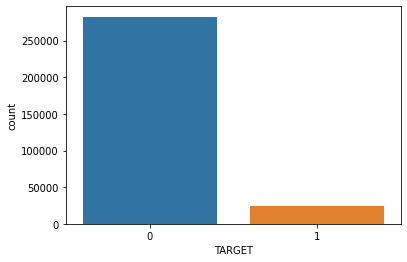

In [ ]:
sns.countplot(x='TARGET',data=target)

**The data is imbalanced we can see that thaere are more than 250000 customers who pay loan regularly and there are customers less than 25000 who do not pay loan installments regularly **

In [ ]:
df_1 = spark.sql('''select TARGET,CODE_GENDER from app_train_imputed ''')
df_1=df_1.toPandas()

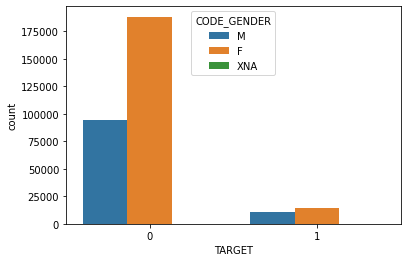

In [ ]:
sns.countplot(x = 'TARGET' , hue = 'CODE_GENDER' , data = df_1)

From the above we can clearly see that Females pay loans most regularly and males pay a little less than female

In [ ]:
df_2 = spark.sql('''select CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE from app_train_imputed ''')

In [ ]:
df_2.show()

+------------+----------------+----------+-----------+---------------+--------------------------+----------+-------------+-----------------+---------------+-------------------+-------------------+---------------------------+-------------------+------------------+------------------------+------------------------+------------------------+------------------------+----------------------+
|CNT_CHILDREN|AMT_INCOME_TOTAL|AMT_CREDIT|AMT_ANNUITY|AMT_GOODS_PRICE|REGION_POPULATION_RELATIVE|DAYS_BIRTH|DAYS_EMPLOYED|DAYS_REGISTRATION|DAYS_ID_PUBLISH|       EXT_SOURCE_2|       EXT_SOURCE_3|YEARS_BEGINEXPLUATATION_AVG|      FLOORSMAX_AVG|    TOTALAREA_MODE|OBS_30_CNT_SOCIAL_CIRCLE|DEF_30_CNT_SOCIAL_CIRCLE|OBS_60_CNT_SOCIAL_CIRCLE|DEF_60_CNT_SOCIAL_CIRCLE|DAYS_LAST_PHONE_CHANGE|
+------------+----------------+----------+-----------+---------------+--------------------------+----------+-------------+-----------------+---------------+-------------------+-------------------+---------------------------+--

In [ ]:
df_2 = df_2.toPandas()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

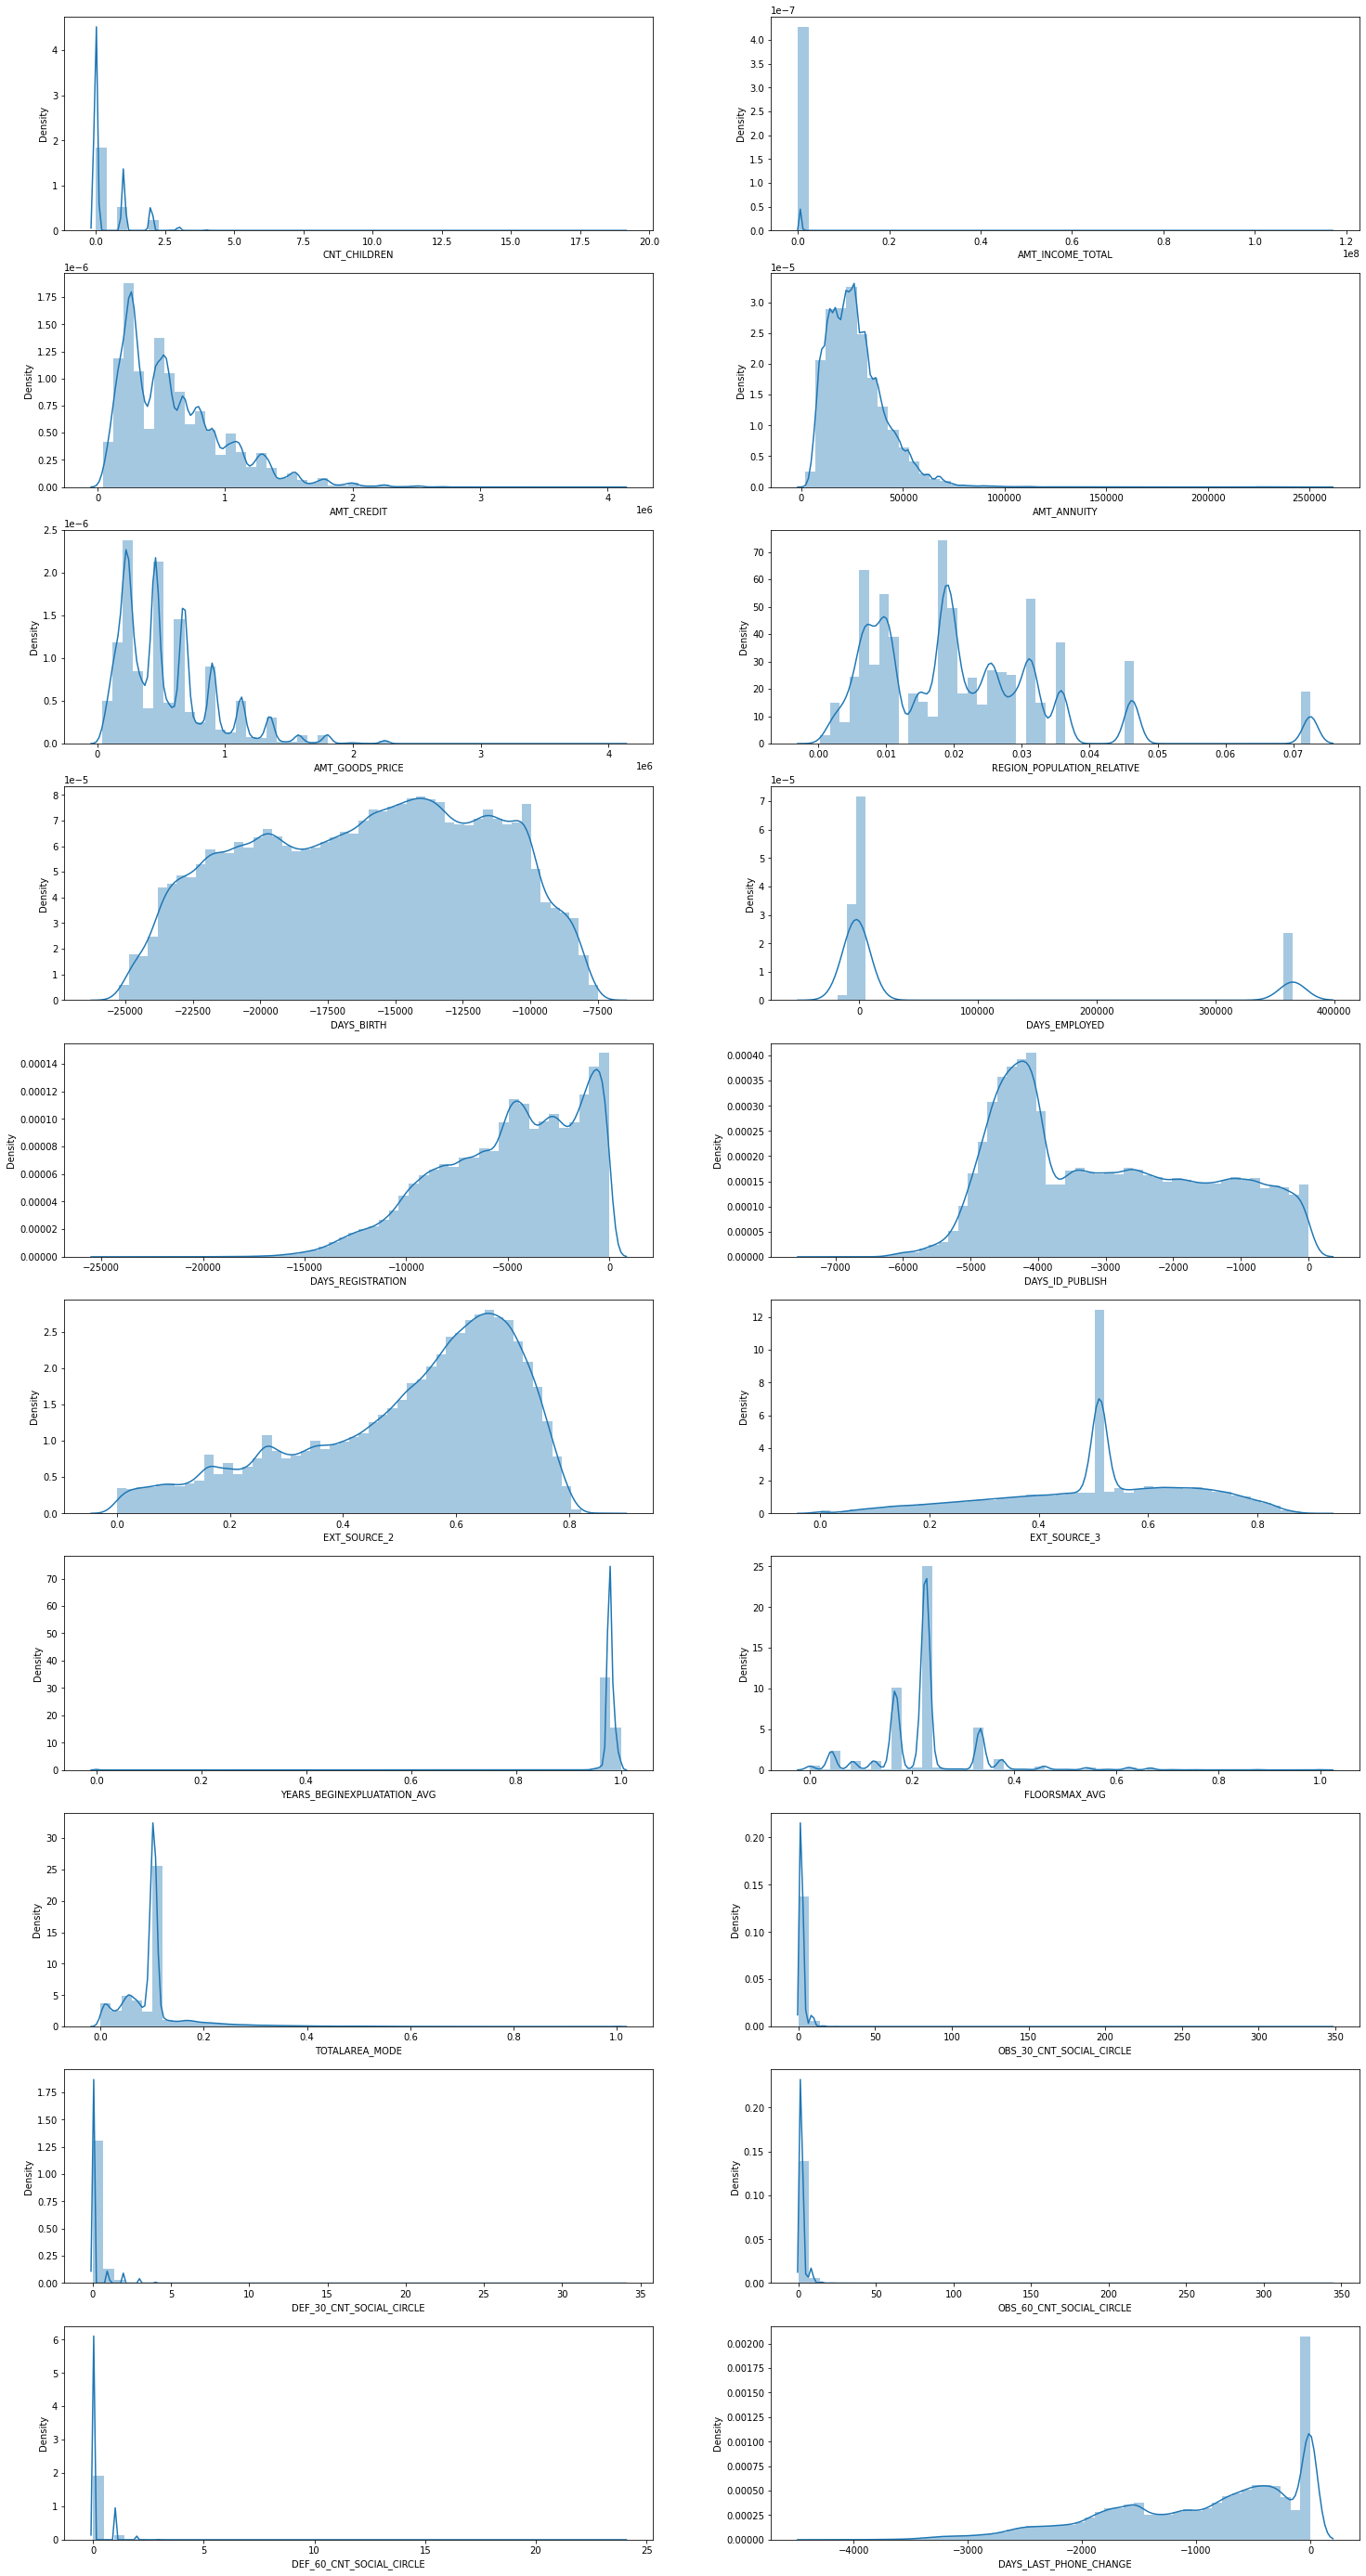

In [ ]:
from IPython.core.pylabtools import figsize
plt.figure(figsize=(25,50))
for i in range(len(df_2.columns)):
  plt.subplot(10, 2,i+1)
  sns.distplot(df_2[df_2.columns[i]])

In [ ]:
df_2 = df_2.append(target,ignore_index=True)

NameError: ignored

In [ ]:
df_2

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,TARGET
0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,-637.0,-3648.0,-2120.0,...,0.139376,0.972200,0.083300,0.014900,2.0,2.0,2.0,2.0,-1134.0,NaN
1,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765.0,-1188.0,-1186.0,-291.0,...,0.510853,0.985100,0.291700,0.071400,1.0,0.0,1.0,0.0,-828.0,NaN
2,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046.0,-225.0,-4260.0,-2531.0,...,0.729567,0.977735,0.226282,0.102547,0.0,0.0,0.0,0.0,-815.0,NaN
3,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005.0,-3039.0,-9833.0,-2437.0,...,0.510853,0.977735,0.226282,0.102547,2.0,0.0,2.0,0.0,-617.0,NaN
4,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932.0,-3038.0,-4311.0,-3458.0,...,0.510853,0.977735,0.226282,0.102547,0.0,0.0,0.0,0.0,-1106.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
615018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
615019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
615020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [ ]:
df_2.isnull().sum()

CNT_CHILDREN                   307511
AMT_INCOME_TOTAL               307511
AMT_CREDIT                     307511
AMT_ANNUITY                    307511
AMT_GOODS_PRICE                307511
REGION_POPULATION_RELATIVE     307511
DAYS_BIRTH                     307511
DAYS_EMPLOYED                  307511
DAYS_REGISTRATION              307511
DAYS_ID_PUBLISH                307511
EXT_SOURCE_2                   307511
EXT_SOURCE_3                   307511
YEARS_BEGINEXPLUATATION_AVG    307511
FLOORSMAX_AVG                  307511
TOTALAREA_MODE                 307511
OBS_30_CNT_SOCIAL_CIRCLE       307511
DEF_30_CNT_SOCIAL_CIRCLE       307511
OBS_60_CNT_SOCIAL_CIRCLE       307511
DEF_60_CNT_SOCIAL_CIRCLE       307511
DAYS_LAST_PHONE_CHANGE         307511
TARGET                         307511
dtype: int64

In [ ]:
df_2['TARGET'].value_counts()

0.0    282686
1.0     24825
Name: TARGET, dtype: int64

In [ ]:
df_2 = df_2.fillna(0)

KeyError: ignored

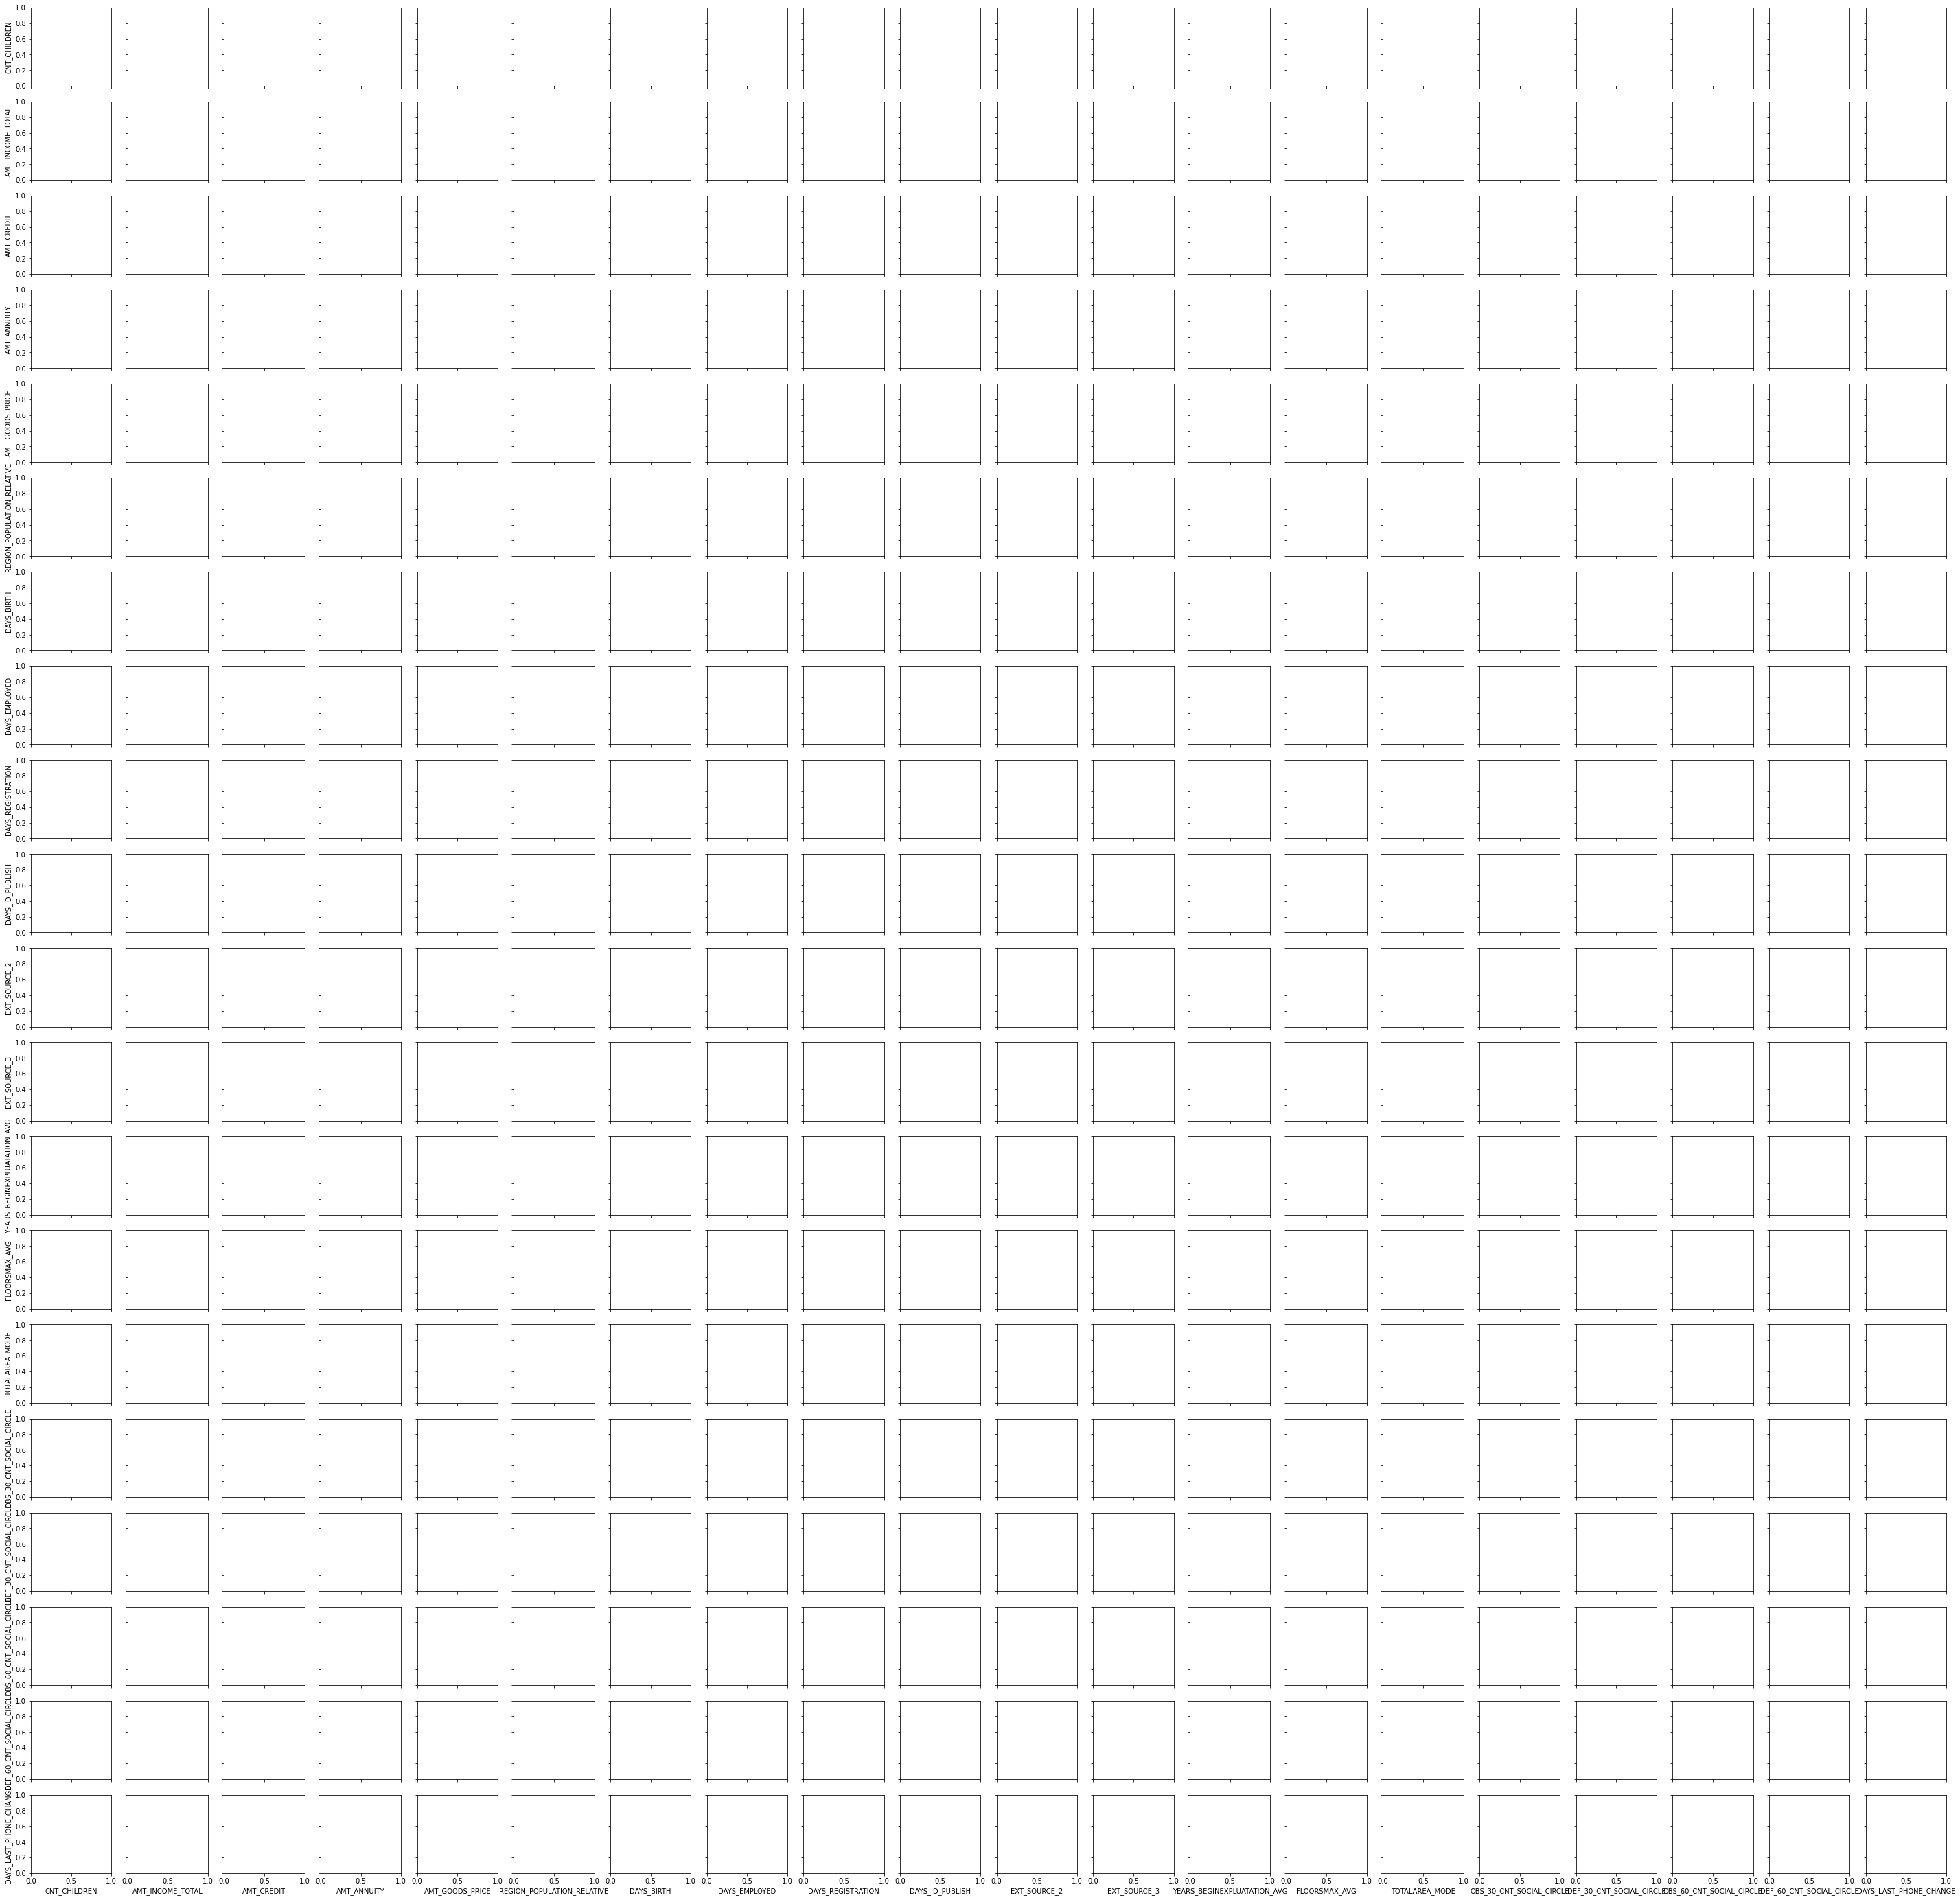

In [ ]:
sns.pairplot(df_2,hue='TARGET')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


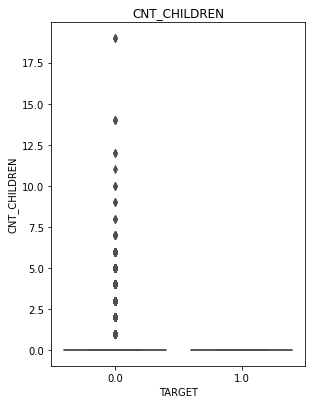

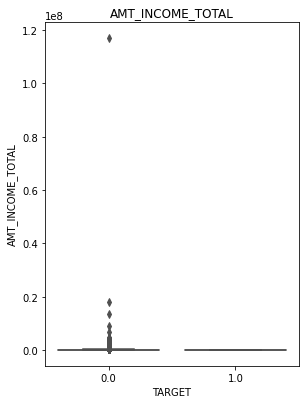

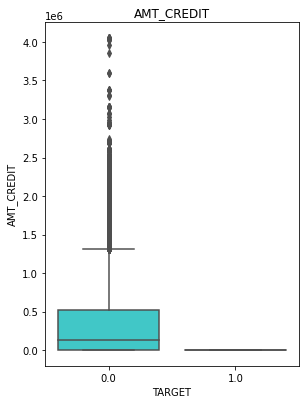

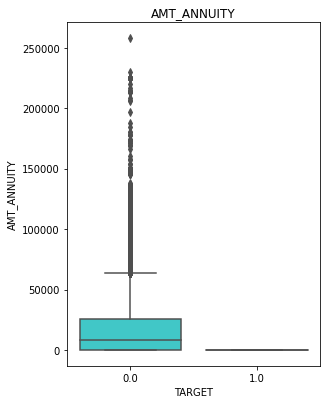

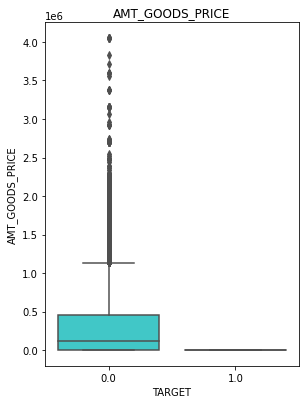

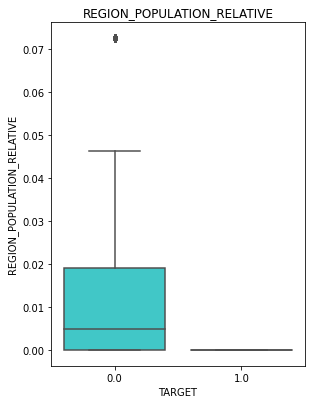

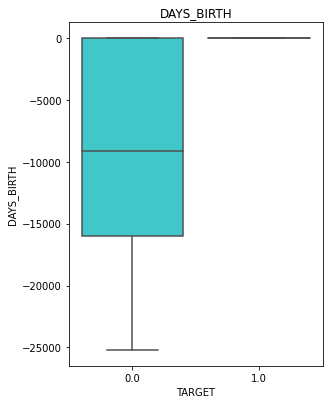

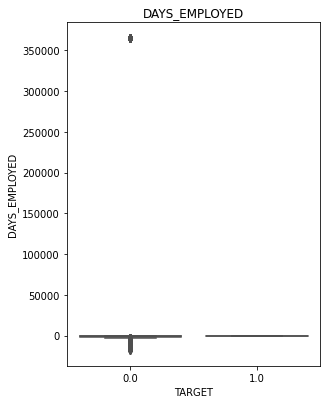

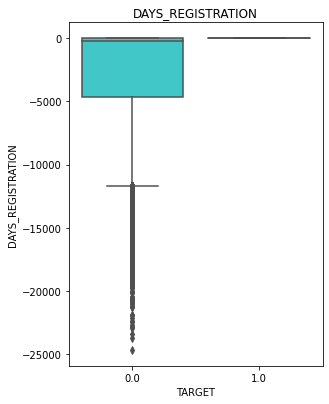

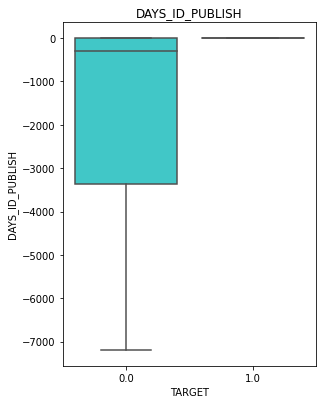

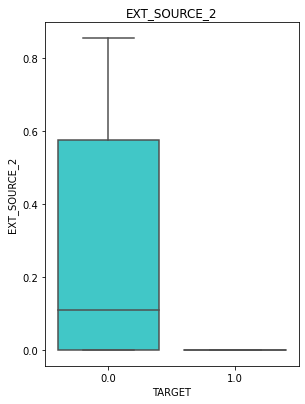

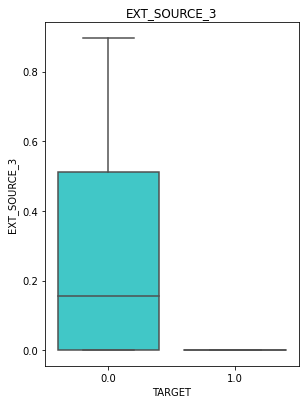

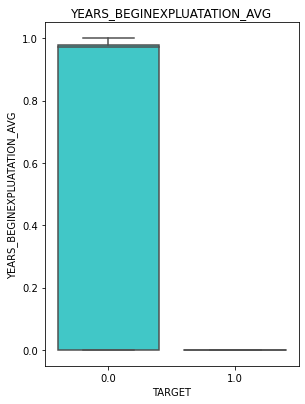

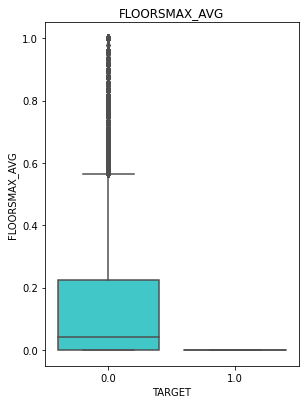

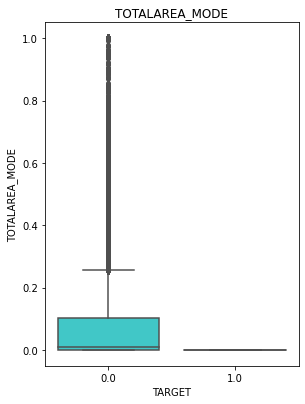

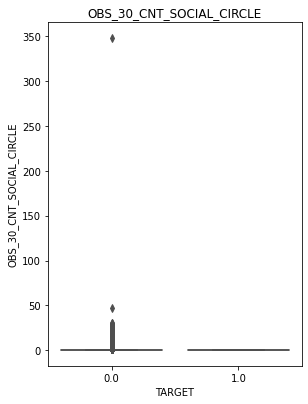

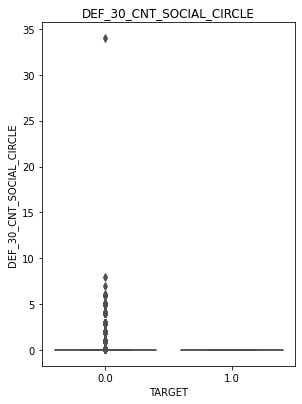

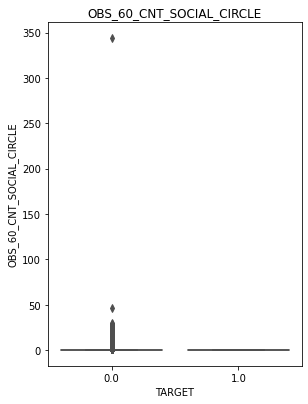

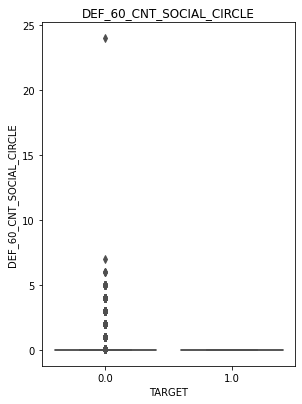

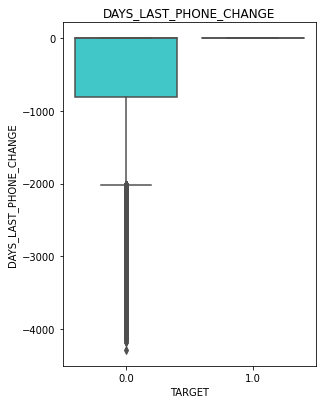

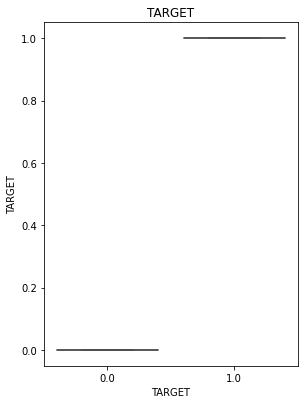

In [ ]:
for i in range(len(df_2.columns)):
  plt.figure(figsize=(10,120))
  plt.subplot(16, 2,i+1)
  sns.boxplot(x='TARGET',y=df_2.columns[i],data=df_2, palette='rainbow')
  plt.title(df_2.columns[i])

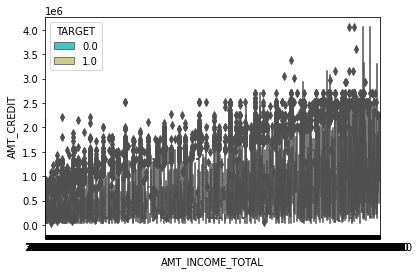

In [ ]:
sns.boxplot(x='AMT_INCOME_TOTAL',y='AMT_CREDIT',data=df_2, palette='rainbow',hue ='TARGET')

In [ ]:
df_3 = spark.sql('''select NAME_INCOME_TYPE,NAME_CONTRACT_TYPE,AMT_INCOME_TOTAL,	AMT_CREDIT,	AMT_ANNUITY,	AMT_GOODS_PRICE,TARGET from app_train_imputed''')

In [ ]:
df_3 = df_3.toPandas()

In [ ]:
df_3

,NAME_INCOME_TYPE,NAME_CONTRACT_TYPE,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,TARGET
0,Working,Cash loans,202500.0,406597.5,24700.5,351000.0,1
1,State servant,Cash loans,270000.0,1293502.5,35698.5,1129500.0,0
2,Working,Revolving loans,67500.0,135000.0,6750.0,135000.0,0
3,Working,Cash loans,135000.0,312682.5,29686.5,297000.0,0
4,Working,Cash loans,121500.0,513000.0,21865.5,513000.0,0
...,...,...,...,...,...,...,...
307506,Working,Cash loans,157500.0,254700.0,27558.0,225000.0,0
307507,Pensioner,Cash loans,72000.0,269550.0,12001.5,225000.0,0
307508,Working,Cash loans,153000.0,677664.0,29979.0,585000.0,0
307509,Commercial associate,Cash loans,171000.0,370107.0,20205.0,319500.0,1


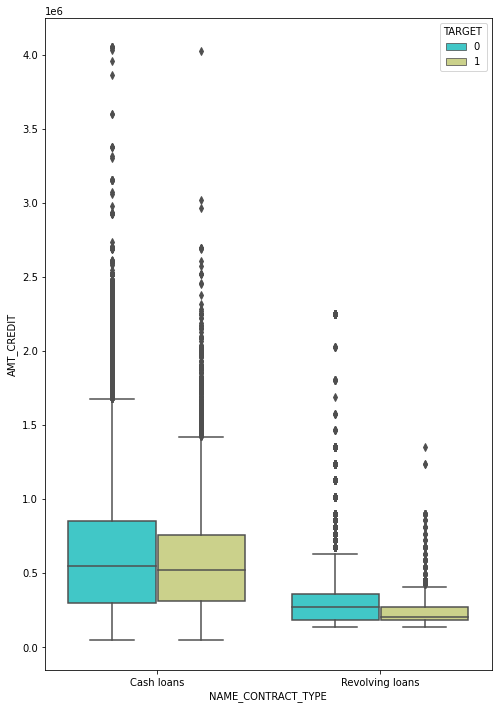

In [ ]:
plt.figure(figsize=(8,12))
sns.boxplot(x='NAME_CONTRACT_TYPE',y='AMT_CREDIT',data=df_3, palette='rainbow',hue ='TARGET')

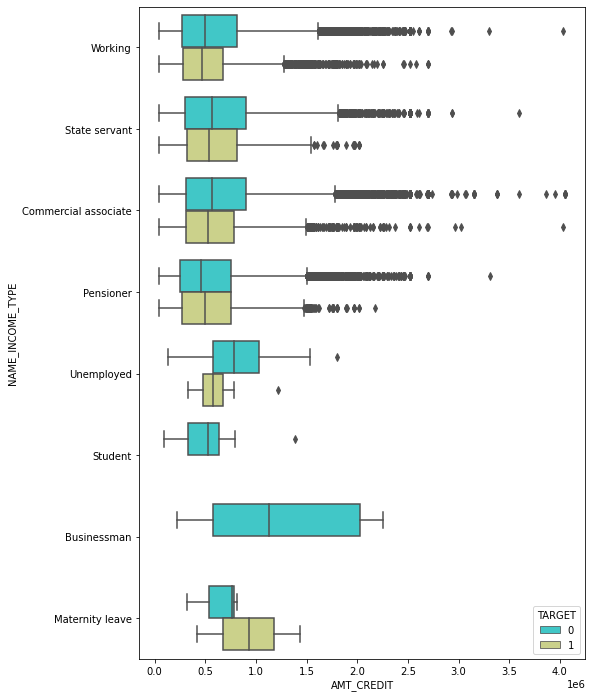

In [ ]:
plt.figure(figsize=(8,12))
sns.boxplot(x='AMT_CREDIT',y='NAME_INCOME_TYPE',data=df_3, palette='rainbow',hue ='TARGET')

One-hot Encoding on categorical columns for doing one hot encoding first we have to ordinal encoding i.e we have to convert all the sring columns into 

In [ ]:
app_train_imputed.orderBy('OCCUPATION_TYPE').show()

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+--------------------+--------------------+--------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+--------------------+-------------------+-------------------+---------------------------+-------------------+------------------+------------------------+------------------------+------------------------+------------------------+----------------------+---------------+---------------+---------------+-----

In [ ]:
from pyspark.sql.functions import desc
jh = app_train_imputed.groupby('ORGANIZATION_TYPE').count().sort(desc("count"))


In [ ]:
jh.show()

+--------------------+-----+
|   ORGANIZATION_TYPE|count|
+--------------------+-----+
|Business Entity T...|67992|
|                 XNA|55374|
|       Self-employed|38412|
|               Other|16683|
|            Medicine|11193|
|Business Entity T...|10553|
|          Government|10404|
|              School| 8893|
|       Trade: type 7| 7831|
|        Kindergarten| 6880|
|        Construction| 6721|
|Business Entity T...| 5984|
|   Transport: type 4| 5398|
|       Trade: type 3| 3492|
|    Industry: type 9| 3368|
|    Industry: type 3| 3278|
|            Security| 3247|
|             Housing| 2958|
|   Industry: type 11| 2704|
|            Military| 2634|
+--------------------+-----+
only showing top 20 rows



In [ ]:
rg = jh.toPandas()

In [ ]:
name_orga_list =[]
for i in range(20,58):
  name_orga_list.append(rg['ORGANIZATION_TYPE'][i])

In [ ]:
name_orga_list

['Bank',
 'Agriculture',
 'Police',
 'Transport: type 2',
 'Postal',
 'Security Ministries',
 'Trade: type 2',
 'Restaurant',
 'Services',
 'University',
 'Industry: type 7',
 'Transport: type 3',
 'Industry: type 1',
 'Hotel',
 'Electricity',
 'Industry: type 4',
 'Trade: type 6',
 'Industry: type 5',
 'Insurance',
 'Telecom',
 'Emergency',
 'Industry: type 2',
 'Advertising',
 'Realtor',
 'Culture',
 'Industry: type 12',
 'Trade: type 1',
 'Mobile',
 'Legal Services',
 'Cleaning',
 'Transport: type 1',
 'Industry: type 6',
 'Industry: type 10',
 'Religion',
 'Industry: type 13',
 'Trade: type 4',
 'Trade: type 5',
 'Industry: type 8']

The first 18 columns of the column almost covers the data *`[italicized text](https:// [link text](https://))`*

In [ ]:
organization = spark.sql('''select ORGANIZATION_TYPE from app_train_imputed''' )

In [ ]:
organization=organization.toPandas()

In [ ]:
from pyspark.sql.functions import regexp_replace
for i in range(len(name_orga_list)):
  app_train_imputed = app_train_imputed.withColumn('ORGANIZATION_TYPE', regexp_replace('ORGANIZATION_TYPE',name_orga_list[i], 'Other')) 

  


In [ ]:
app_train_imputed.groupby('ORGANIZATION_TYPE').count().sort(desc("count")).show(58)

+--------------------+-----+
|   ORGANIZATION_TYPE|count|
+--------------------+-----+
|Business Entity T...|67992|
|                 XNA|55374|
|               Other|49345|
|       Self-employed|38412|
|            Medicine|11193|
|Business Entity T...|10553|
|          Government|10404|
|              School| 8893|
|       Trade: type 7| 7831|
|        Kindergarten| 6880|
|        Construction| 6721|
|Business Entity T...| 5984|
|   Transport: type 4| 5398|
|       Trade: type 3| 3492|
|    Industry: type 9| 3368|
|    Industry: type 3| 3278|
|            Security| 3247|
|             Housing| 2958|
|              Other1| 2704|
|            Military| 2634|
|              Other2|  369|
|         Legal Other|  305|
|              Other0|  109|
|              Other3|   67|
+--------------------+-----+



In [ ]:
app_train_imputed = app_train_imputed.withColumn('ORGANIZATION_TYPE', regexp_replace('ORGANIZATION_TYPE','Other1', 'Other'))
app_train_imputed = app_train_imputed.withColumn('ORGANIZATION_TYPE', regexp_replace('ORGANIZATION_TYPE','Other2', 'Other'))
app_train_imputed = app_train_imputed.withColumn('ORGANIZATION_TYPE', regexp_replace('ORGANIZATION_TYPE','Military', 'Other'))
app_train_imputed = app_train_imputed.withColumn('ORGANIZATION_TYPE', regexp_replace('ORGANIZATION_TYPE','Legal Other', 'Other'))
app_train_imputed = app_train_imputed.withColumn('ORGANIZATION_TYPE', regexp_replace('ORGANIZATION_TYPE','Other0', 'Other'))
app_train_imputed = app_train_imputed.withColumn('ORGANIZATION_TYPE', regexp_replace('ORGANIZATION_TYPE','Other3', 'Other'))


# As the data has class imbalance adding weights to balance the data 

In [ ]:
from pyspark.sql.functions import when
ratio = 0.91
def weight_balance(labels):
    return when(labels == 1, ratio).otherwise(1*(1-ratio))
new_df = app_train_imputed.withColumn('weights', weight_balance(col('TARGET')))

In [ ]:
# app_train_imputed = app_train_imputed.withColumn('ORGANIZATION_TYPE', regexp_replace('ORGANIZATION_TYPE', 'Industry: type 1', 'Industry: type 11')) 



In [ ]:
from pyspark.ml.feature import OneHotEncoder

from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCols=["NAME_CONTRACT_TYPE","CODE_GENDER","FLAG_OWN_CAR","FLAG_OWN_REALTY","NAME_TYPE_SUITE","NAME_INCOME_TYPE","NAME_EDUCATION_TYPE","NAME_FAMILY_STATUS","NAME_HOUSING_TYPE","OCCUPATION_TYPE","WEEKDAY_APPR_PROCESS_START","ORGANIZATION_TYPE"],outputCols=["NAME_CONTRACT_TYPE_indexed","CODE_GENDER_indexed","FLAG_OWN_CAR_indexed","FLAG_OWN_REALTY_indexed","NAME_TYPE_SUITE_indexed","NAME_INCOME_TYPE_indexed","NAME_EDUCATION_TYPE_indexed","NAME_FAMILY_STATUS_indexed","NAME_HOUSING_TYPE_indexed","OCCUPATION_TYPE_indexed","WEEKDAY_APPR_PROCESS_START_indexed","ORGANIZATION_TYPE_indexed"])

In [ ]:
app_train_indexer = indexer .fit(new_df).transform(new_df)

In [ ]:
app_train_indexer .show()

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+--------------------+--------------------+--------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+--------------------+-------------------+-------------------+---------------------------+-------------------+------------------+------------------------+------------------------+------------------------+------------------------+----------------------+---------------+---------------+---------------+-----

In [ ]:
app_train_indexer = app_train_indexer.drop("NAME_CONTRACT_TYPE","CODE_GENDER","FLAG_OWN_CAR","FLAG_OWN_REALTY","NAME_TYPE_SUITE","NAME_INCOME_TYPE","NAME_EDUCATION_TYPE","NAME_FAMILY_STATUS","NAME_HOUSING_TYPE","OCCUPATION_TYPE","WEEKDAY_APPR_PROCESS_START","ORGANIZATION_TYPE")

In [ ]:

encoder = OneHotEncoder(inputCols=["NAME_CONTRACT_TYPE_indexed","CODE_GENDER_indexed","FLAG_OWN_CAR_indexed","FLAG_OWN_REALTY_indexed","NAME_TYPE_SUITE_indexed","NAME_INCOME_TYPE_indexed","NAME_EDUCATION_TYPE_indexed","NAME_FAMILY_STATUS_indexed","NAME_HOUSING_TYPE_indexed","OCCUPATION_TYPE_indexed","WEEKDAY_APPR_PROCESS_START_indexed","ORGANIZATION_TYPE_indexed"],
                                 outputCols=["NAME_CONTRACT_TYPE_encoded","CODE_GENDER_encoded","FLAG_OWN_CAR_encoded","FLAG_OWN_REALTY_encoded","NAME_TYPE_SUITE_encoded","NAME_INCOME_TYPE_encoded","NAME_EDUCATION_TYPE_encoded","NAME_FAMILY_STATUS_encoded","NAME_HOUSING_TYPE_encoded","OCCUPATION_TYPE_encoded","WEEKDAY_APPR_PROCESS_START_encoded","ORGANIZATION_TYPE_encoded"])

In [ ]:
app_train_encoded = encoder.fit(app_train_indexer).transform(app_train_indexer)

In [ ]:
app_train_encoded.show()

+----------+------+------------+----------------+----------+-----------+---------------+--------------------------+----------+-------------+-----------------+---------------+----------+--------------+---------------+----------------+----------+----------+---------------+--------------------+---------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+-------------------+-------------------+---------------------------+-------------------+------------------+------------------------+------------------------+------------------------+------------------------+----------------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------

In [ ]:
app_train_indexer.columns[57]

'FLAG_DOCUMENT_21'

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [ ]:
features = VectorAssembler(inputCols=[
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'YEARS_BEGINEXPLUATATION_AVG',
 'FLOORSMAX_AVG',
 'TOTALAREA_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21',
 "NAME_CONTRACT_TYPE_encoded","CODE_GENDER_encoded","FLAG_OWN_CAR_encoded","FLAG_OWN_REALTY_encoded","NAME_TYPE_SUITE_encoded","NAME_INCOME_TYPE_encoded","NAME_EDUCATION_TYPE_encoded","NAME_FAMILY_STATUS_encoded","NAME_HOUSING_TYPE_encoded","OCCUPATION_TYPE_encoded","WEEKDAY_APPR_PROCESS_START_encoded","ORGANIZATION_TYPE_encoded"],outputCol='features')


In [ ]:
M1 = features.transform(app_train_encoded)

In [ ]:
M1.show()

+----------+------+------------+----------------+----------+-----------+---------------+--------------------------+----------+-------------+-----------------+---------------+----------+--------------+---------------+----------------+----------+----------+---------------+--------------------+---------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+-------------------+-------------------+---------------------------+-------------------+------------------+------------------------+------------------------+------------------------+------------------------+----------------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------

In [ ]:
final_data = M1.select('features','TARGET')

In [ ]:
final_data= final_data.withColumnRenamed('TARGET','label')

In [ ]:
final_data.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(128,[1,2,3,4,5,6...|    1|
|(128,[1,2,3,4,5,6...|    0|
|(128,[1,2,3,4,5,6...|    0|
|(128,[1,2,3,4,5,6...|    0|
|(128,[1,2,3,4,5,6...|    0|
|(128,[1,2,3,4,5,6...|    0|
|(128,[0,1,2,3,4,5...|    0|
|(128,[1,2,3,4,5,6...|    0|
|(128,[1,2,3,4,5,6...|    0|
|(128,[1,2,3,4,5,6...|    0|
|(128,[0,1,2,3,4,5...|    0|
|(128,[1,2,3,4,5,6...|    0|
|(128,[1,2,3,4,5,6...|    0|
|(128,[0,1,2,3,4,5...|    0|
|(128,[1,2,3,4,5,6...|    0|
|(128,[1,2,3,4,5,6...|    0|
|(128,[1,2,3,4,5,6...|    0|
|(128,[0,1,2,3,4,5...|    0|
|(128,[1,2,3,4,5,6...|    0|
|(128,[0,1,2,3,4,5...|    0|
+--------------------+-----+
only showing top 20 rows



In [ ]:
(train, test) = final_data.randomSplit([0.8, 0.2])

# **Traning The data set**

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
dtc = DecisionTreeClassifier(featuresCol="features", labelCol="label")

dtc = dtc.fit(train)

pred = dtc.transform(test)
pred.show(3)

+--------------------+-----+------------------+--------------------+----------+
|            features|label|     rawPrediction|         probability|prediction|
+--------------------+-----+------------------+--------------------+----------+
|(128,[0,1,2,3,4,5...|    0|[194969.0,13634.0]|[0.93464140017161...|       0.0|
|(128,[0,1,2,3,4,5...|    0|   [7192.0,2143.0]|[0.77043385109801...|       0.0|
|(128,[0,1,2,3,4,5...|    0|[194969.0,13634.0]|[0.93464140017161...|       0.0|
+--------------------+-----+------------------+--------------------+----------+
only showing top 3 rows



In [ ]:
pred.select('label').show()

+-----+
|label|
+-----+
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
|    1|
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
+-----+
only showing top 20 rows



In [ ]:
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
from sklearn.metrics import confusion_matrix
acc = evaluator.evaluate(pred)
 
print("Prediction Accuracy: ", acc)
 
y_pred=pred.select("prediction").collect()
y_orig=pred.select("label").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)

Prediction Accuracy:  0.8805365665478793
Confusion Matrix:
[[56622     9]
 [ 4978     6]]


In [ ]:
from pyspark.ml.classification import LogisticRegression
LR = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=15)
LR_model = LR.fit(train)

spark-3.2.0-bin-hadoop3.2/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


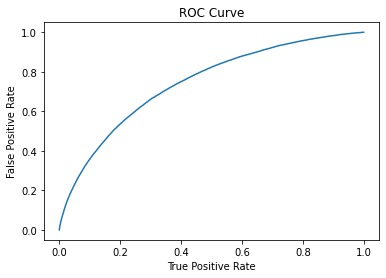

Training set ROC: 0.7420700270407796


In [ ]:
trainingSummary = LR_model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set ROC: ' + str(trainingSummary.areaUnderROC))

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
predictions_LR = LR_model.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test_SET (Area Under ROC): " + str(evaluator.evaluate(predictions_LR, {evaluator.metricName: "areaUnderROC"})))

Test_SET (Area Under ROC): 0.7432655380656501


In [ ]:
y_predictions=predictions_LR.select("prediction").collect()
y_predictions_orig=predictions_LR.select("label").collect()

cm_1 = confusion_matrix(y_predictions_orig, y_predictions)
print("Confusion Matrix:")
print(cm_1)
acc_1 = evaluator.evaluate(predictions_LR)
 
print("Prediction Accuracy: ", acc_1)

Confusion Matrix:
[[56560    71]
 [ 4914    70]]
Prediction Accuracy:  0.7432696355129165


In [ ]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=15)
GBT_Model = gbt.fit(train)
gbt_predictions = GBT_Model.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test_SET (Area Under ROC): " + str(evaluator.evaluate(gbt_predictions, {evaluator.metricName: "areaUnderROC"})))

Test_SET (Area Under ROC): 0.730875482868128


In [ ]:
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
from sklearn.metrics import confusion_matrix
acc = evaluator.evaluate(gbt_predictions)
 
print("Prediction Accuracy: ", acc)
 
y_pred=pred.select("prediction").collect()
y_orig=pred.select("label").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)

Prediction Accuracy:  0.8806873750736721
Confusion Matrix:
[[56622     9]
 [ 4978     6]]


In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from time import *
rf = RandomForestClassifier(featuresCol="features", labelCol="label")
model = rf.fit(train)
rf_predictions = model.transform(test)

In [ ]:
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
from sklearn.metrics import confusion_matrix
acc_rf = evaluator.evaluate(rf_predictions)
 
print("Prediction Accuracy: ", acc_rf)


Prediction Accuracy:  0.8803706296835604


In [ ]:
y_pred=rf_predictions.select("prediction").collect()
y_orig=rf_predictions.select("label").collect()

cm_rf = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm_rf)

Confusion Matrix:
[[56631     0]
 [ 4984     0]]


In [ ]:
spark.sql('''select * from prev_app where SK_ID_CURR = '271877'  ''').show()

+----------+----------+------------------+-----------+---------------+----------+----------------+---------------+--------------------------+-----------------------+---------------------------+----------------------+-------------------+---------------------+------------------------+----------------------+--------------------+-------------+--------------------+------------------+---------------+----------------+--------------------+--------------+-----------------+----------------+----------------+--------------------+-----------+----------------+--------------------+------------------+--------------+-------------------------+-------------+----------------+-------------------------+
|SK_ID_PREV|SK_ID_CURR|NAME_CONTRACT_TYPE|AMT_ANNUITY|AMT_APPLICATION|AMT_CREDIT|AMT_DOWN_PAYMENT|AMT_GOODS_PRICE|WEEKDAY_APPR_PROCESS_START|HOUR_APPR_PROCESS_START|FLAG_LAST_APPL_PER_CONTRACT|NFLAG_LAST_APPL_IN_DAY|  RATE_DOWN_PAYMENT|RATE_INTEREST_PRIMARY|RATE_INTEREST_PRIVILEGED|NAME_CASH_LOAN_PURPOSE|NAM

In [ ]:
spark.sql('''select * from app_train where SK_ID_CURR = '271877'  ''').show()

+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+----------------+-------------------+------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+-----------------+------------+------------------+------------+--------------+----------------+---------------------------+---------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+-----------------------+----------------

In [ ]:
spark.sql('''select * from bureau where SK_ID_CURR = '271877'  ''').show()

+----------+------------+-------------+---------------+-----------+------------------+-------------------+-----------------+----------------------+------------------+--------------+-------------------+--------------------+----------------------+---------------+------------------+-----------+
|SK_ID_CURR|SK_ID_BUREAU|CREDIT_ACTIVE|CREDIT_CURRENCY|DAYS_CREDIT|CREDIT_DAY_OVERDUE|DAYS_CREDIT_ENDDATE|DAYS_ENDDATE_FACT|AMT_CREDIT_MAX_OVERDUE|CNT_CREDIT_PROLONG|AMT_CREDIT_SUM|AMT_CREDIT_SUM_DEBT|AMT_CREDIT_SUM_LIMIT|AMT_CREDIT_SUM_OVERDUE|    CREDIT_TYPE|DAYS_CREDIT_UPDATE|AMT_ANNUITY|
+----------+------------+-------------+---------------+-----------+------------------+-------------------+-----------------+----------------------+------------------+--------------+-------------------+--------------------+----------------------+---------------+------------------+-----------+
|    271877|     6051771|       Active|     currency 1|       -564|                 0|             1128.0|             nu

In [ ]:
spark.sql('''select * from pos_cash where SK_ID_CURR = '271877'  ''').show()

+----------+----------+--------------+--------------+---------------------+--------------------+------+----------+
|SK_ID_PREV|SK_ID_CURR|MONTHS_BALANCE|CNT_INSTALMENT|CNT_INSTALMENT_FUTURE|NAME_CONTRACT_STATUS|SK_DPD|SK_DPD_DEF|
+----------+----------+--------------+--------------+---------------------+--------------------+------+----------+
|   2154916|    271877|           -13|           5.0|                  0.0|              Active|     0|         0|
|   2030495|    271877|            -1|           1.0|                  0.0|           Completed|     0|         0|
|   2154916|    271877|           -14|          12.0|                  9.0|              Active|     0|         0|
|   2154916|    271877|           -17|          12.0|                 12.0|              Active|     0|         0|
|   2154916|    271877|           -15|          12.0|                 10.0|              Active|     0|         0|
|   2154916|    271877|           -12|           5.0|                  0.0|     

In [ ]:
spark.sql('''select * from install_payments where SK_ID_CURR = '186401'  ''').show(50)
install_payments.groupby('SK_ID_CURR').count().sort(desc("count")).show()

+----------+----------+----------------------+---------------------+---------------+------------------+--------------+-----------+
|SK_ID_PREV|SK_ID_CURR|NUM_INSTALMENT_VERSION|NUM_INSTALMENT_NUMBER|DAYS_INSTALMENT|DAYS_ENTRY_PAYMENT|AMT_INSTALMENT|AMT_PAYMENT|
+----------+----------+----------------------+---------------------+---------------+------------------+--------------+-----------+
|   2243411|    186401|                   0.0|                   26|        -2157.0|           -2180.0|        9000.0|     9000.0|
|   2704200|    186401|                   1.0|                    5|         -878.0|            -886.0|      39386.25|   39386.25|
|   2704200|    186401|                   1.0|                   10|         -728.0|            -732.0|      39386.25|   39386.25|
|   2717650|    186401|                   2.0|                    2|        -1337.0|           -1397.0|     13779.405|  13779.405|
|   2243411|    186401|                   0.0|                   68|         -969.0

In [ ]:
credit_bal.groupby('SK_ID_CURR').count().sort(desc("count")).show()
# credit_bal.count()

+----------+-----+
|SK_ID_CURR|count|
+----------+-----+
|    186401|  192|
|    311118|  178|
|    120076|  140|
|    128827|  129|
|    246089|  128|
|    191826|  128|
|    432607|  128|
|    173773|  127|
|    116448|  127|
|    264667|  127|
|    155019|  126|
|    437045|  126|
|    386299|  126|
|    192917|  126|
|    445828|  125|
|    286836|  125|
|    393185|  124|
|    452300|  123|
|    449948|  123|
|    303407|  123|
+----------+-----+
only showing top 20 rows



In [ ]:
pos_cash
install_payments
credit_bal